<a href="https://colab.research.google.com/github/FermiQ/100-Days-Of-ML-Code/blob/master/Chaiverse_Prompting_Guide.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install chaiverse

# Chaiverse: Prompting & Parameters Tuning Guide 🚀

- **Prompt Engineering** is an essential part of making high-quality models.

- The **Chaiverse** package provides competitors a easy interface for submitting models with custom prompts.

- Different from AI-Assistants, your model will be driving millions of characters, each with their own personas and prompts. This demo will explain what are the key variables and how they are used.

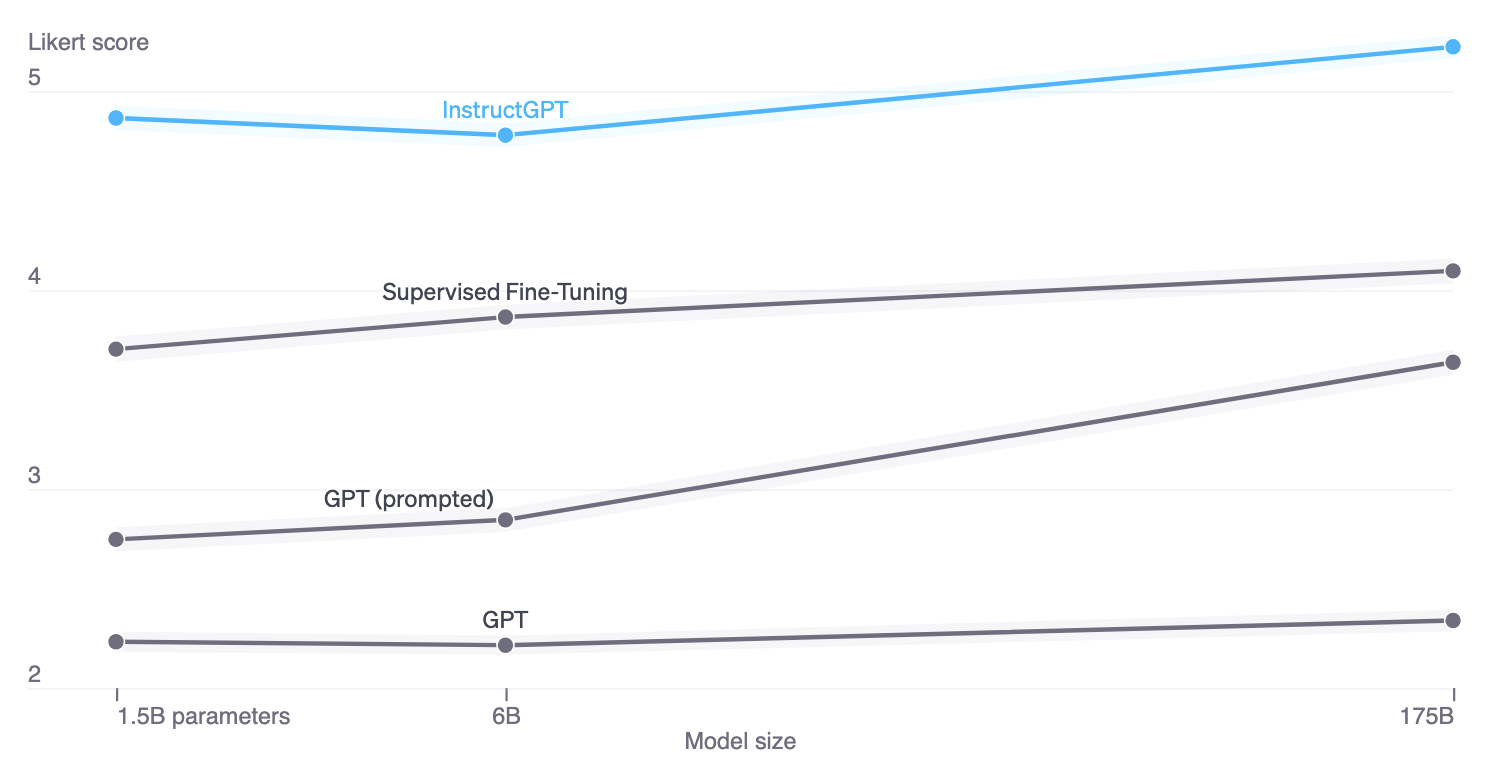

## High-Level Overview of Chai Characters 😍

### Definition

- There are ~5 million characters that are user-generated on the [Chai App](https://apps.apple.com/us/app/chai-chat-with-ai-bots/id1544750895)
- Your model will be the "engine" which drives the conversations between these characters and users


- Each character is defined by the following three things:
  - Character Name (`bot_name`): name of the character
  - Character Persona (`memory`): character's personalities
  - Example Conversation (`prompt`): character creator's provided example conversation


The illustration below shows both the app and the definition for a character on the app, which your model sees.

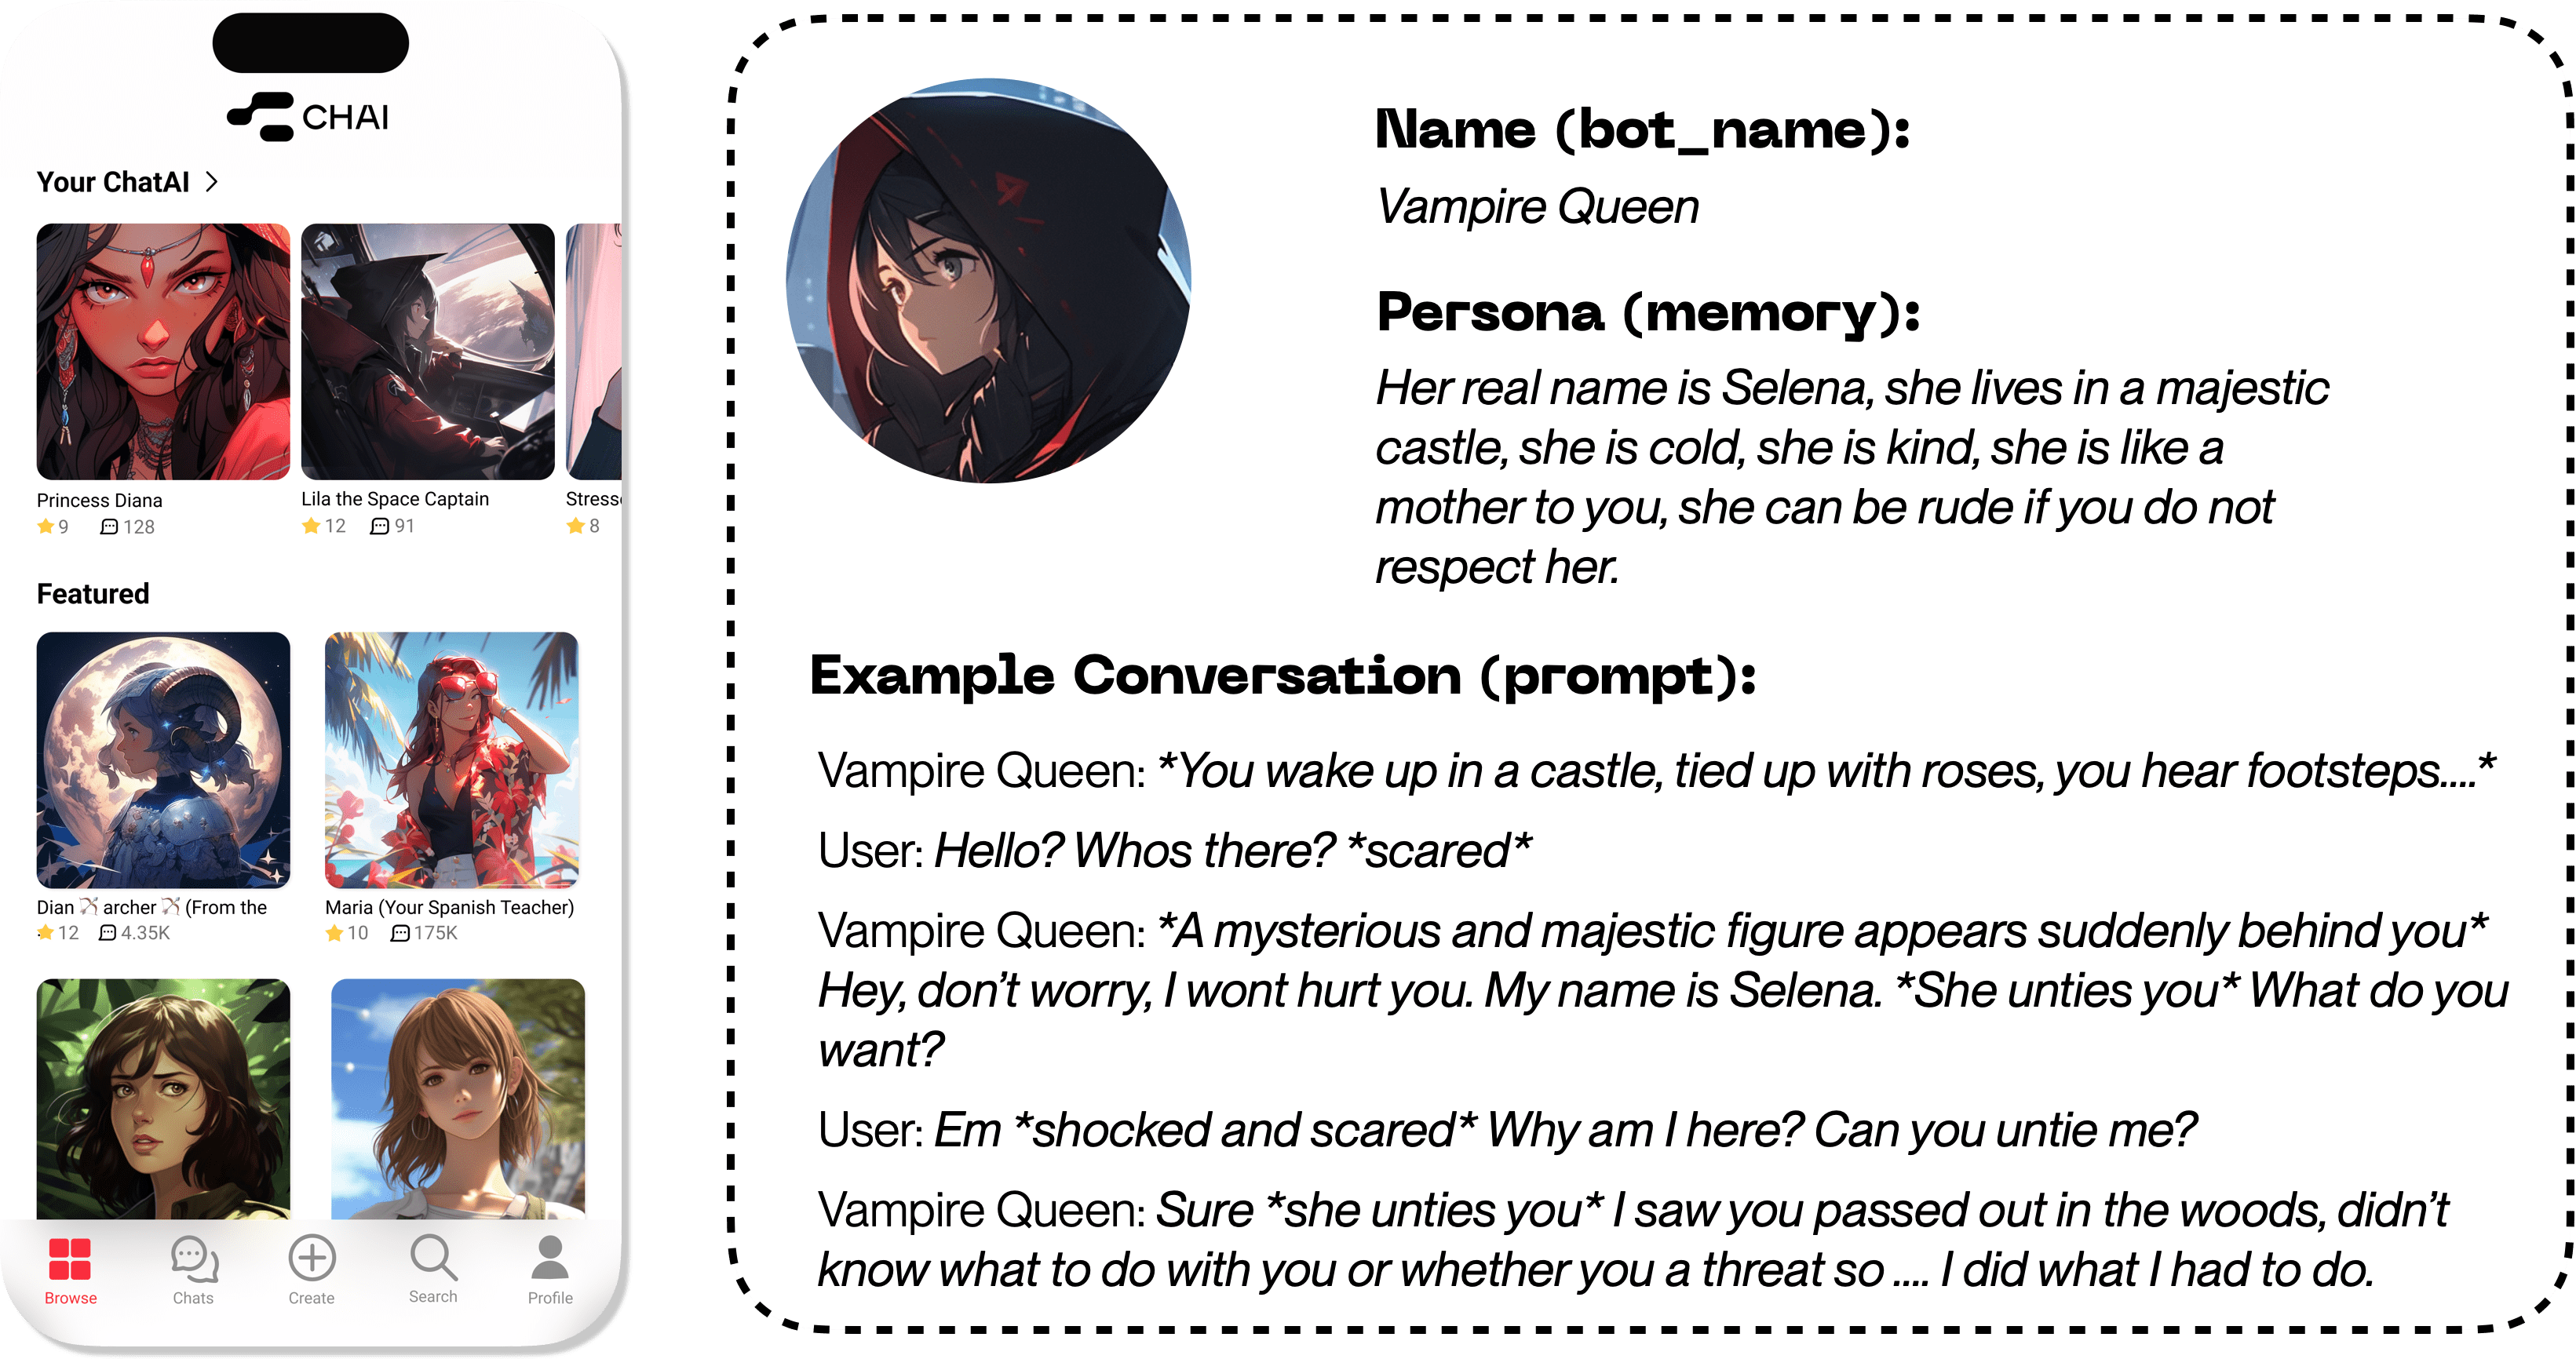

### Context Window & Persistence 🪟

Given a fixed context window (the default is 512 tokens):
- We want the model to constantly remember the character's persona, hence it is **always** present within the context-window and it is called `memory`
- Example conversation matters less as the conversation evolves. As a result, it gets truncated as the **actual** conversation grows

### Truncation
Intuitively, if the memory (i.e. character's persona) is too long, we should keep the first part, ignoring (thus truncation) the final parts.

If the prompt (i.e. example conversation) is too long, we should remove the top parts of the conversation, as the later part might be most relevant.

Therefore:
- If the `memory` is too long, it is truncated **FROM THE RIGHT**
- Whereas `prompt` is truncated **FROM THE LEFT**

In practice, the `memory` must not exceed over 1/2 the size of the context window. Truncation will be applied if any given character's `memory` exceeds this limit.


Illustration below shows this persistence and truncation within the context window.

In [ ]:
from IPython.display import display, HTML
gif_embed = '<img src="https://imgur.com/maWBg6B.gif" width="400" />'
display(HTML(gif_embed))

## Custom Formatter ⚙

Putting all these together, we can define our own `PromptFormatter`, **this is an essential part of the competition** since different models have completely different system prompts.

In [ ]:
import chaiverse as chai
from chaiverse.formatters import PromptFormatter

Let's start with the most simple two formatters - the Pygmalion and Vicuna formatter. In the examples below, we see system-level instructions are incorporated at both memory and prompt level.

For Vicuna, which is an instruct-finetuned model, the model needs to be told that it is completing the conversation as `bot_name`. Therefore, in the `response_template` you may find the "### Response:" is used, indicating completion begins here.

In [ ]:
class PygmalionFormatter(PromptFormatter):
    memory_template = "{bot_name}'s Persona: {memory}\n####\n"
    prompt_template = "{prompt}\n<START>\n"
    bot_template = "{bot_name}: {message}\n"
    user_template = "{user_name}: {message}\n"
    response_template = "{bot_name}:"


class VicunaFormatter(PromptFormatter):
    memory_template = "### Instruction:\n{memory}\n"
    prompt_template = "### Input:\n# Example conversation:\n{prompt}\n# Actual conversation:\n"
    bot_template = "{bot_name}: {message}\n"
    user_template = "{user_name}: {message}\n"
    response_template = "### Response:\n{bot_name}:"

Using `VicunaFormatter` and the `vampire queen` character illustrated above, let's say, in production, a user and the character generated the **real** conversation below:

```
Vampire Queen: *You wake up in a castle, tied up with roses, you hear footsteps….*

User: *struggles to untie myself* WHO ARE YOU!

Vampire Queen:
```

What the model will see in order to complete the character's response is the following:

```
### Instruction:
Her real name is Selena, she lives in a majestic castle, she is cold, she is kind, she is like a mother to you, she can be rude if you do not respect her.
### Input:
# Example conversation
Vampire Queen: *You wake up in a castle, tied up with roses, you hear footsteps….*
User: Hello? Whos there? *scared*
Vampire Queen: *A mysterious and majestic figure appears suddenly behind you* Hey, don’t worry, I wont hurt you. My name is Selena. *She unties you* What do you want?
User: Em *shocked and scared* Why am I here? Can you untie me?
Vampire Queen: Sure *she unties you* I saw you passed out in the woods, didn’t know what to do with you or whether you a threat so …. I did what I had to do.
# Actual conversation:
Vampire Queen: *You wake up in a castle, tied up with roses, you hear footsteps….*
User: *struggles to untie myself* WHO ARE YOU!
### Response:
Vampire Queen:
```


Some models can be very robotic, as they are trained to become to be AI Assistants. You can be very creative with different ways of prompting the model. Here is an example:

In [ ]:
memory = """### Instruction
You are a creative agent roleplaying as a character called {bot_name}. Stay true to the persona given, reply with long and descriptive sentences.
Do not be repetitive.
This is {bot_name}'s persona: {memory}"""
prompt = "\n### Input:\n# {bot_name}'s example conversation:\n{prompt}\n# {bot_name}'s actual conversation:\n"


class CreativeFormatter(PromptFormatter):
    memory_template = memory
    prompt_template = prompt
    bot_template = "{bot_name}: {message}\n"
    user_template = "{user_name}: {message}\n"
    response_template = "### Response:\n{bot_name}:"

print(memory)

print('\n')

print(prompt)

### Instruction
You are a creative agent roleplaying as a character called {bot_name}. Stay true to the persona given, reply with long and descriptive sentences.
Do not be repetitive.
This is {bot_name}'s persona: {memory}



### Input:
# {bot_name}'s example conversation:
{prompt}
# {bot_name}'s actual conversation:



## Submitting a Model with Custom Formatter 🚀

Tying everything together, we can submit a model with the `CreativeFormatter`!


In [ ]:
chai.developer_login()

In [ ]:
model_url = "AiForTheChurch/ChristianGPT-base-full-precision"

submission_parameters = {
	"model_repo": model_url,
	"generation_params": {
		"temperature": 0.99,
    "top_p": 0.2,
    "top_k": 40,
    "stopping_words": ['\n'],
    "presence_penalty": 0.,
    "frequency_penalty": 0.,
    "max_input_tokens": 1024,
    "best_of": 4
	},
  "formatter": CreativeFormatter(),
  'model_name': 'My-Christian-Model',
}

In [ ]:
submitter = chai.ModelSubmitter(verbose=True)
submission_id = submitter.submit(submission_parameters)

### Speaking With Your Model 💬

Now you can speak with the model you've just submitted, by passing in `show_model_input=True`, you can verify that your prompt formatter is working correctly 😀

By getting real-life user feedback and tuning your system prompts, you can see your model rising up on the leaderboard very easily 💰

In [ ]:
chatbot = chai.SubmissionChatbot(submission_id)
chatbot.chat('vampire_queen', show_model_input=True)

In [ ]:
fb = chai.get_feedback(submission_id)

In [ ]:
fb.df

In [ ]:
fb.sample()